# Terraform AWS Schema

#### DO THIS ONCE:

Generate the `aws-schema.json` with:

    `terraform providers schema -json > aws-schema.json`

In [44]:
import json

In [45]:
AWS_SCHEMA_PATH = 'aws-schema.json'
with open(AWS_SCHEMA_PATH) as f:
    schema = json.loads(f.read())

In [46]:
aws = schema['provider_schemas']['registry.terraform.io/hashicorp/aws']

aws_resource_schemas: dict[str, any] = aws['resource_schemas']
aws_data_source_schemas: dict[str, any] = aws['data_source_schemas']

In [47]:
from difflib import get_close_matches
import re

for elem_k, elem_v in aws_resource_schemas.items():
    print(elem_k)

    # get foreign keys without the 'aws' prefix
    fk_attrs = [re.sub(r'^aws_', '', fk) for fk in aws_resource_schemas.keys()]

    # Iterate block attributes
    elem_attrs = elem_v['block']['attributes']
    elem_attr_keys = [k for k, v in elem_attrs.items() 
                      if 'string' in v['type'] 
                      and k != elem_k
                      and not k.endswith('_state')
                      and not k.endswith('_type') ] 
    # alternatively, check only if ends with '_id', '_ids' or k itself

    # find possible references by closest match
    for k in elem_attr_keys:
        fk_attrs_for_k = get_close_matches(k, [fk for fk in fk_attrs if fk in k])
        if fk_attrs_for_k:
            #print(f'\t{k}')
            #print(f'\t\t{fk_attrs_for_k}')
            elem_attrs[k]['mm_type'] = f'aws_{fk_attrs_for_k[0]}'

    # Descent into blocks
    elem_blocktypes = elem_v['block'].get('block_types', {})
    for bt_k, bt_v in elem_blocktypes.items():
        print(f'\t{bt_k}')
        if bt_attrs := bt_v['block'].get('attributes'):
            # Iterate block attributes
            bt_attr_keys = [k for k, v in bt_attrs.items() 
                              if 'string' in v['type'] 
                              and k != elem_k
                              and not k.endswith('_state')
                              and not k.endswith('_type') ]
            print(f'\t\t{bt_attr_keys}')
            
            # find possible references by closest match
            for k in bt_attr_keys:
                fk_attrs_for_k = get_close_matches(k, [fk for fk in fk_attrs if fk in k])
                if fk_attrs_for_k:
                    print(f'\t\t{fk_attrs_for_k}')
                    bt_attrs[k]['mm_type'] = f'aws_{fk_attrs_for_k[0]}'

aws_accessanalyzer_analyzer
aws_accessanalyzer_archive_rule
	filter
		['contains', 'criteria', 'eq', 'exists', 'neq']
aws_account_alternate_contact
	timeouts
		['create', 'delete', 'update']
aws_account_primary_contact
aws_acm_certificate
	options
		['certificate_transparency_logging_preference']
	validation_option
		['domain_name', 'validation_domain']
aws_acm_certificate_validation
	timeouts
		['create']
aws_acmpca_certificate
	validity
		['type', 'value']
aws_acmpca_certificate_authority
	certificate_authority_configuration
		['key_algorithm', 'signing_algorithm']
	revocation_configuration
	timeouts
		['create']
aws_acmpca_certificate_authority_certificate
aws_acmpca_permission
aws_acmpca_policy
aws_alb
	access_logs
		['bucket', 'prefix']
	subnet_mapping
		['allocation_id', 'ipv6_address', 'outpost_id', 'private_ipv4_address', 'subnet_id']
		['subnet']
	timeouts
		['create', 'delete', 'update']
aws_alb_listener
	default_action
		['target_group_arn', 'type']
	timeouts
		['read']
aws_

Search for `mm_type` in the output to view associated types.

> Should data_source_schemas be considered too?

Now `aws_resource_schemas` has the `mm_type` on its attributes.

In [48]:
AWS_SELECTED_RESOURCES_IDS = [
    "aws_instance",
    "aws_vpc",
    "aws_subnet",
    "aws_security_group",
    "aws_route_table",
    "aws_iam_user",
    "aws_iam_role",
    "aws_s3_bucket",
    "aws_lambda_function",
    "aws_sqs_queue",
    "aws_cloudwatch_metric_alarm",
    "aws_autoscaling_group",
    "aws_lb", # load balancer
    # "aws_apigatewayv2_api", # (rest, http), use v1 for REST
]

AWS_SELECTED_RESOURCES = { k: aws_resource_schemas[k] for k in AWS_SELECTED_RESOURCES_IDS }

In [49]:
from dataclasses import make_dataclass
from typing import Optional, ForwardRef

aws_resource_dataclasses = {} # the ones we want

def get_type(v):
        match v:
            case 'string': return str
            case 'bool': return bool
            case 'number': return int
            case ['list', a]: return list[get_type(a)]
            case ['set', a]: return set[get_type(a)]
            case ['map', a]: return dict[get_type(a)]
            case _: return any 

def type_transformer(v):
    if mm_type := v.get('mm_type'):
        # gen a dataclass for the dependency
        if mm_type not in aws_resource_dataclasses :
            aws_resource_dataclasses[mm_type] = '__temp__'
            aws_resource_dataclasses[mm_type] = make_class(
                mm_type, aws_resource_schemas[mm_type])
        return ForwardRef(mm_type)
    if optional := v.get('optional'):
        if optional:
            return Optional[get_type(v['type'])]
    return get_type(v['type'])

def make_class(id, attrs):
    fields = [ (k, type_transformer( v ))
              for (k, v) in attrs['block']['attributes'].items() ]
    return make_dataclass(id, fields)

aws_resource_dataclasses |= {
     k: make_class(k, v)
     for k, v in AWS_SELECTED_RESOURCES.items()
}

for k, v in AWS_SELECTED_RESOURCES.items():
     if k not in aws_resource_dataclasses:
          aws_resource_dataclasses[k] = make_class(k, v)


In [50]:
list(map(lambda r: f">>>{r}<<<" if r in AWS_SELECTED_RESOURCES_IDS else r, aws_resource_dataclasses.keys()))

['aws_ami',
 'aws_iam_instance_profile',
 'aws_placement_group',
 'aws_network_interface',
 '>>>aws_security_group<<<',
 '>>>aws_vpc<<<',
 'aws_default_network_acl',
 '>>>aws_subnet<<<',
 'aws_default_route_table',
 'aws_default_security_group',
 '>>>aws_instance<<<',
 '>>>aws_route_table<<<',
 'aws_kms_key',
 '>>>aws_s3_bucket<<<',
 'aws_s3_object',
 'aws_launch_configuration',
 '>>>aws_iam_user<<<',
 '>>>aws_iam_role<<<',
 '>>>aws_lambda_function<<<',
 '>>>aws_sqs_queue<<<',
 '>>>aws_cloudwatch_metric_alarm<<<',
 '>>>aws_autoscaling_group<<<',
 '>>>aws_lb<<<']

In [51]:
# aws_instance = aws_resource_dataclasses['aws_instance']
#??aws_instance # use ?? to view class def

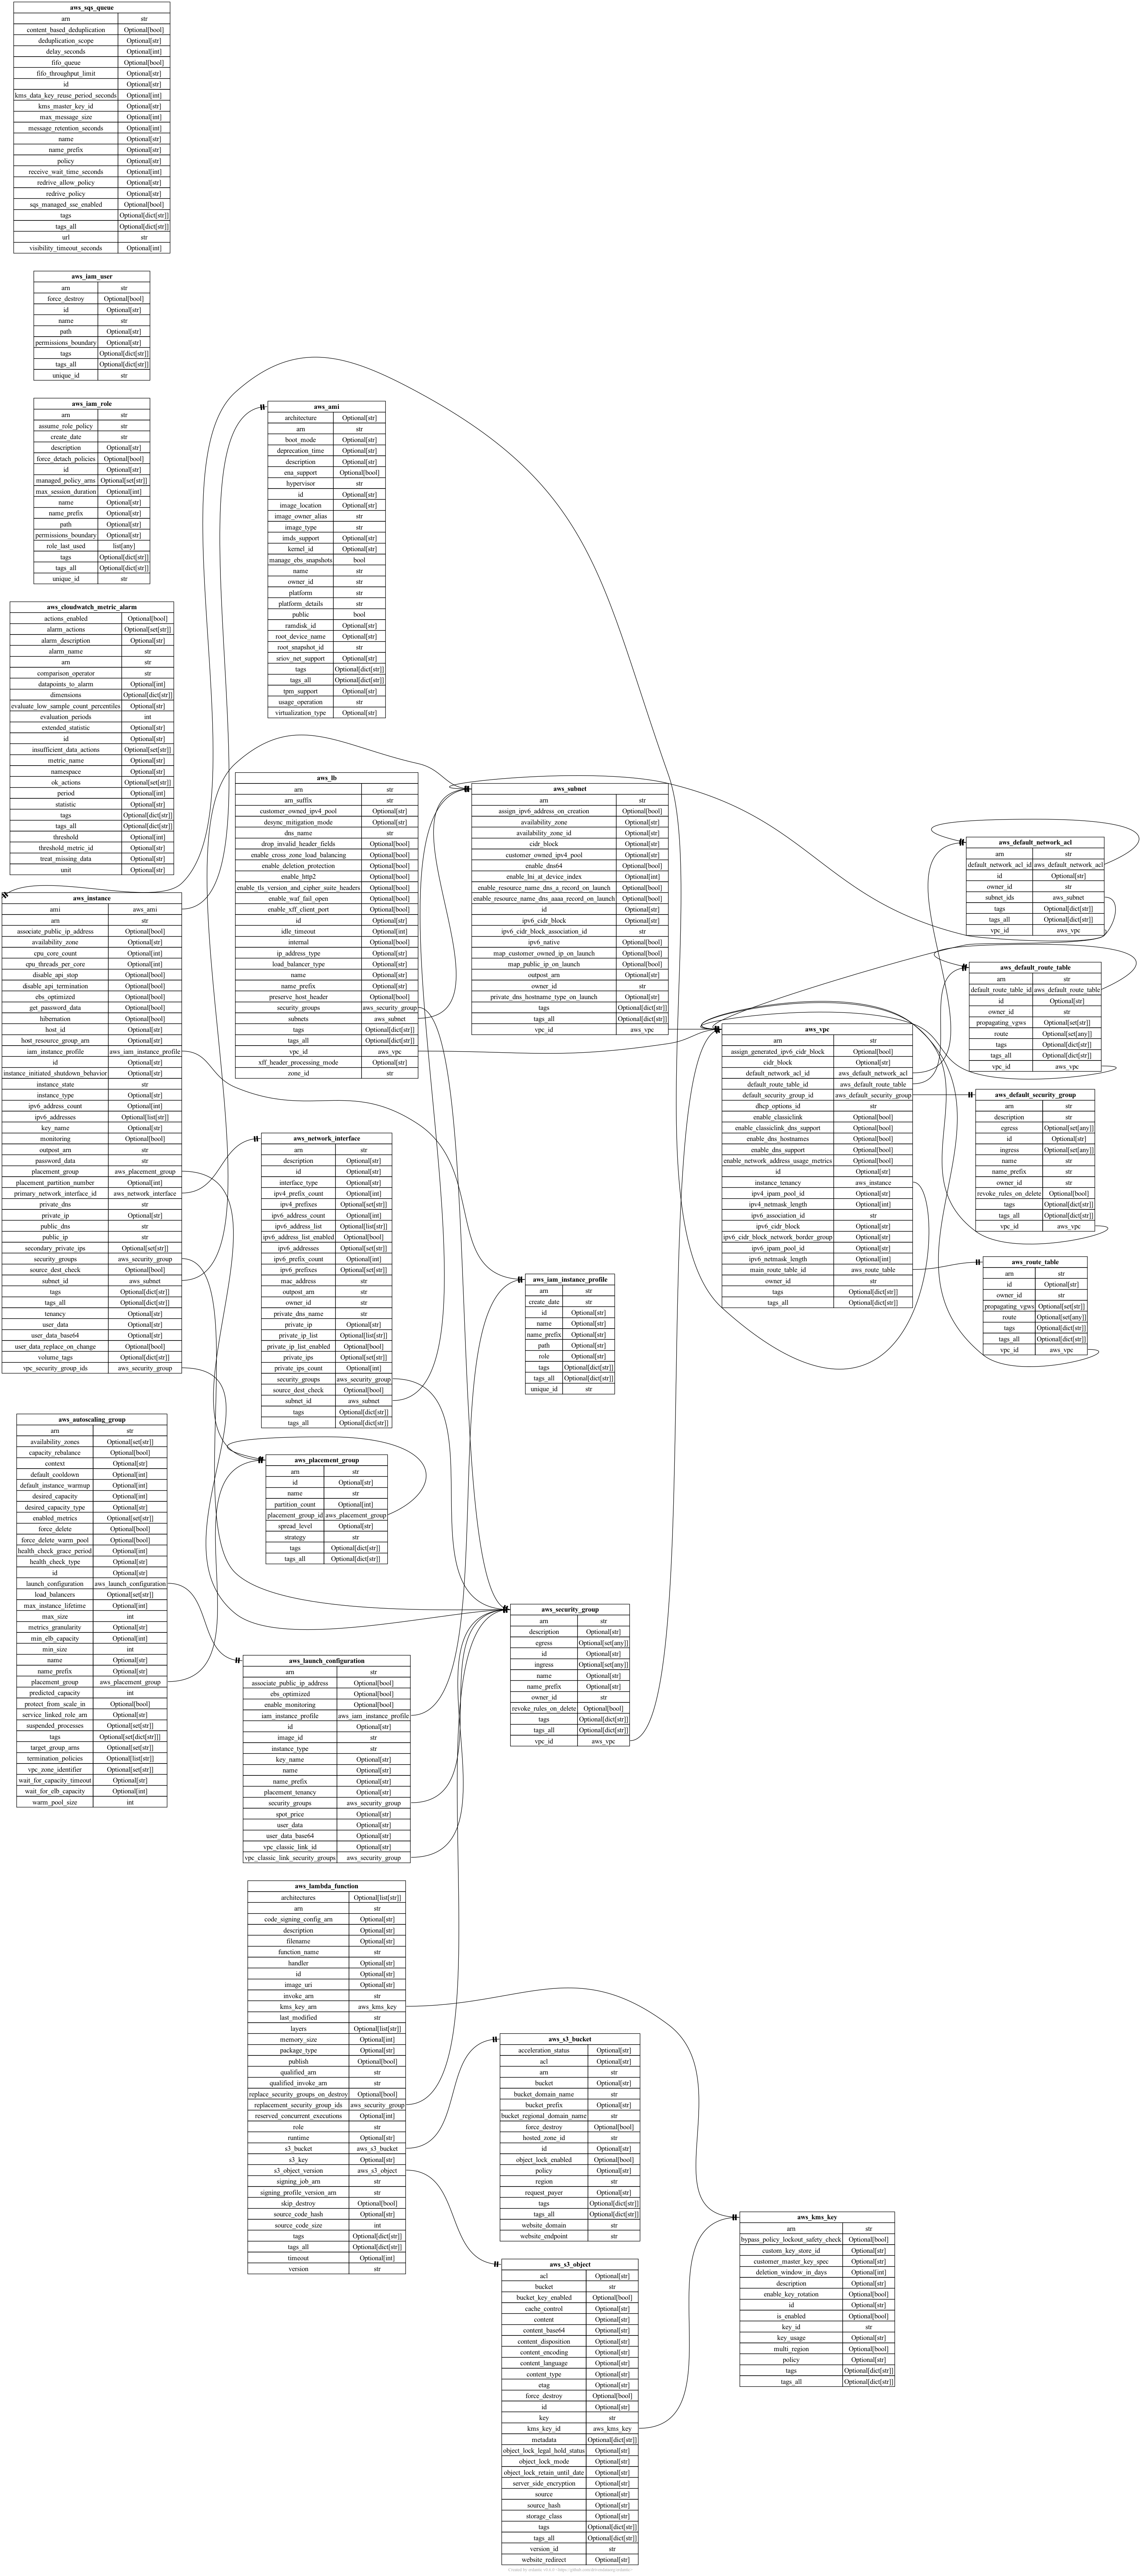

In [55]:
from typing import get_type_hints
import erdantic as erd

for _, dt in aws_resource_dataclasses.items():
   _ = get_type_hints(dt, localns=aws_resource_dataclasses)

#get_type_hints(aws_resource_dataclasses['aws_instance'], localns=aws_resource_dataclasses)

diagram = erd.create(*(aws_resource_dataclasses.values()))
diagram

## Importing a Terraform model

From this terraform model, we should be able to extract and validate its configuration.

In [53]:
import hcl2

AWS_TF_PATH = 'main.tf'
with open(AWS_TF_PATH) as f:
    tf = hcl2.load(f)

tf_resources = tf['resource']

In [ ]:
from tfparse import load_from_path

parsed = load_from_path('assets/examples/aws_ec2_ebs_docker_host')